# AI vs IA
---

#### Group 12

This notebook contains our work for the **AI vs IA** topic of the **IA Data Hack** hackathon.<br><br>
The structure of the notebook is as follows:
- Understanding of the topic
- Analysis and data transformation
- Benchmark of different machine learning models
- Optimization of the best machine learning model
- Deep learning models
- Conclusion

We are using the `scikit-learn` library for benchmarking, which runs only on CPU, so it will take a long time to train the different models.<br>
You can directly find in the conclusion section a cell with our best model.

## Understanding the Topic
---

The subject of this hackathon is, as previously stated, **AI vs IA**. From a text, we need to identify whether this text was written by a **human** or by an **AI**.<br>
Thus, we consider this problem as a **classification** problem, more precisely a **binary classification** problem. Binary classification is a common problem in artificial intelligence, which can be solved using ***machine learning*** or ***deep learning*** models. We will use both types of models and compare them in our benchmark to select the most suitable one.<br>
For a binary classification problem, we use the `binary cross-entropy` loss function, which is the most appropriate, and it is calculated as follows:

$$
BCE = -y \cdot \log(p) - (1 - y) \cdot \log(1 - p)
$$

Where:
- *y* is the true label (0 - AI or 1 - Human)
- *p* is the predicted probability (between 0 and 1)

## Data Analysis and Transformation
---

### Importing Libraries

In [3]:
import os
import pandas as pd
import s3fs
import numpy as np
import time
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoTokenizer, TFBertModel 
from tensorflow.keras.layers import Input

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sosorina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Retrieving the dataset from AWS

In [6]:
# Creating an s3 object file system
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [5]:
file_path = "data.csv"

# Uploading data into the service
fs.download("civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv", file_path)

In [6]:
# Creating a dataframe from the csv file
df = pd.read_csv(file_path).drop(['src'], axis=1)


### Analyse des textes



In [7]:
# Creation of a dataframe to study the length of the texts in the dataframe
text_df = pd.DataFrame(df["label"])
text_df['text_length'] = df["text"].apply(len)
print("Longueur moyenne des textes: ", int(text_df['text_length'].mean()))
print("Longueur minimum des textes: ", text_df['text_length'].min())
print("Longueur maximum des textes: ", text_df['text_length'].max())

Longueur moyenne des textes:  1230
Longueur minimum des textes:  24
Longueur maximum des textes:  63723


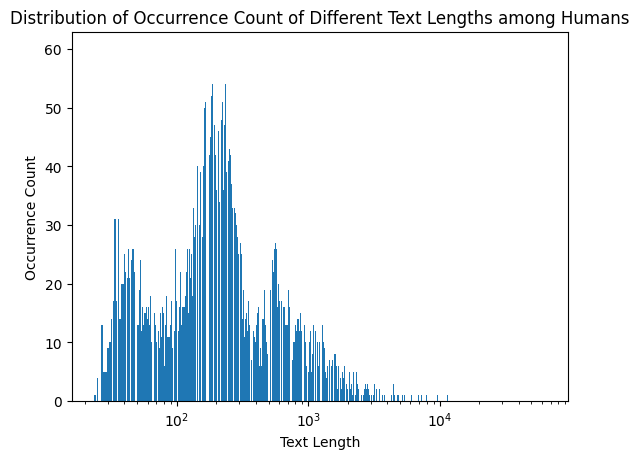

In [8]:
values, count = np.unique(text_df[text_df["label"] == 1]["text_length"].values, return_counts=True)
plt.bar(values, count)
plt.xscale("log")
plt.xlabel("Text Length")
plt.ylabel("Occurrence Count")
plt.title("Distribution of Occurrence Count of Different Text Lengths among Humans")
plt.show()

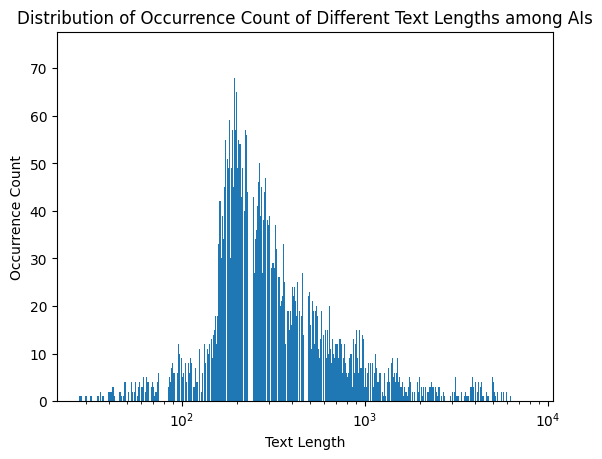

In [9]:
values, count = np.unique(text_df[text_df["label"] == 0]["text_length"].values, return_counts=True)
plt.bar(values, count)
plt.xscale("log")
plt.xlabel("Text Length")
plt.ylabel("Occurrence Count")
plt.title("Distribution of Occurrence Count of Different Text Lengths among AIs")
plt.show()

We notice that the length of texts written by humans is more extensive than that of texts generated by AIs, which appears to be centered around 200 characters.

In [10]:
human_df = df[df.label == 1]
human_strings = " ".join(list(human_df['text']))
human_strings = human_strings.lower()
human_tokens = word_tokenize(human_strings)
print("Number of tokens in the human set:", len(human_tokens))
vocab_human = set(human_tokens)
print("Vocabulary size for human set:", len(vocab_human))

ia_df = df[df.label != 1]
ia_strings = " ".join(list(ia_df['text']))
ia_strings = ia_strings.lower()  # Corrected from test_strings.lower()
ia_tokens = word_tokenize(ia_strings)
print("Number of tokens in the non-human set:", len(ia_tokens))
vocab_non_human = set(ia_tokens)
print("Vocabulary size for non-human set:", len(vocab_non_human))

# Calculate the ratio of vocabulary sizes
vocab_ratio = len(vocab_human) / len(vocab_non_human)
print("Vocabulary size ratio (human / non-human):", vocab_ratio)

# Calculate the average token length
avg_token_length_human = sum(len(token) for token in human_tokens) / len(human_tokens)
print("Average token length in the human set:", avg_token_length_human)

avg_token_length_non_human = sum(len(token) for token in ia_tokens) / len(ia_tokens)
print("Average token length in the non-human set:", avg_token_length_non_human)

Number of tokens in the human set: 6814676
Vocabulary size for human set: 125025
Number of tokens in the non-human set: 7092532
Vocabulary size for non-human set: 99359
Vocabulary size ratio (human / non-human): 1.2583158043055989
Average token length in the human set: 4.103762086414673
Average token length in the non-human set: 4.243358225243115


Here we observe that human vocabulary is more comprehensive than that of AIs, with a more comprehensive vocabulary by about **25%**.

### Occurrences of words with spelling mistakes

The list of banned words has been established based on the most common mistakes in the English language (contraction mistakes).

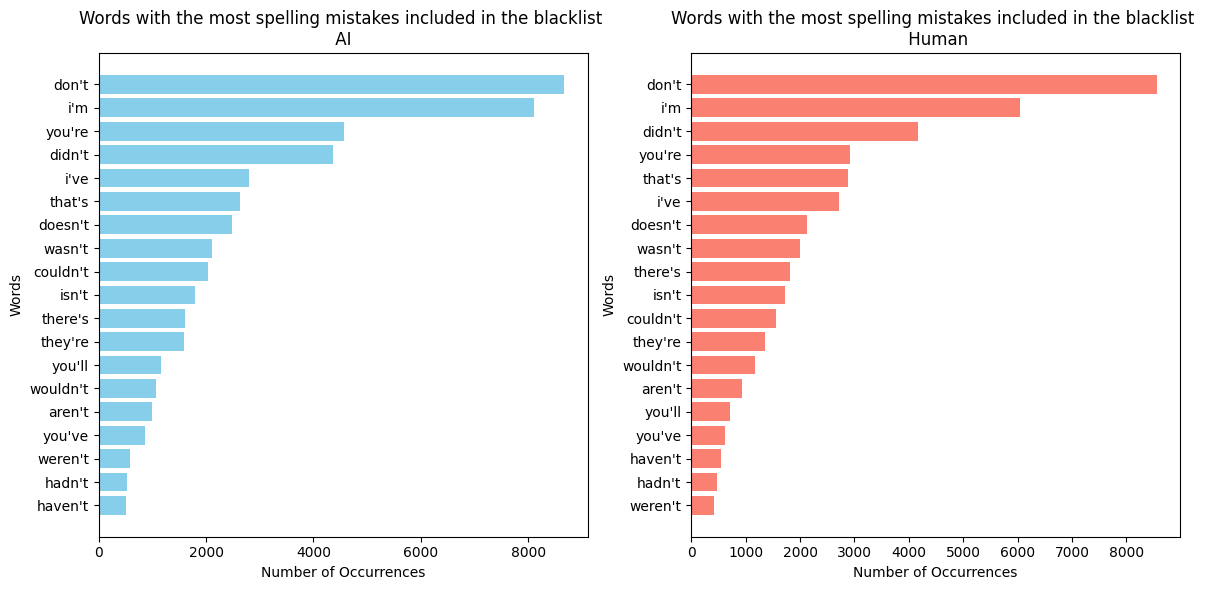

In [12]:
blacklisted_words = {"didn't", "don't", "I'm", "you're", "I've", "doesn't", "wasn't", "couldn't", "that's", "isn't", "there's", "they're", "wouldn't", "aren't", "you'll", "Don't", "you've", "haven't", "hadn't", "weren't"}

# Initialize dictionaries with lowercase keys
blacklisted_counts_label_0 = {word.lower(): 0 for word in blacklisted_words}
blacklisted_counts_label_1 = {word.lower(): 0 for word in blacklisted_words}

# Iterate through each text to count exact occurrences of words from the blacklist
for index, row in df.iterrows():
    text = row['text']
    words_in_text = text.split()
    for word in words_in_text:
        word_lower = word.lower()  # Convert the word in text to lowercase
        if word_lower in blacklisted_counts_label_0:  # Check if the lowercase word is in the dictionary
            if row['label'] == 0:
                blacklisted_counts_label_0[word_lower] += 1
            else:
                blacklisted_counts_label_1[word_lower] += 1


# Filter words with at least one occurrence for each label
filtered_counts_label_0 = {word: count for word, count in blacklisted_counts_label_0.items() if count > 0}
filtered_counts_label_1 = {word: count for word, count in blacklisted_counts_label_1.items() if count > 0}

# Sort dictionary by value to get words with the most occurrences for each label
sorted_counts_label_0 = sorted(filtered_counts_label_0.items(), key=lambda x: x[1], reverse=True)
sorted_counts_label_1 = sorted(filtered_counts_label_1.items(), key=lambda x: x[1], reverse=True)

# Extract data for the plot for label 0
words_label_0 = [word for word, count in sorted_counts_label_0]
counts_label_0 = [count for word, count in sorted_counts_label_0]

# Extract data for the plot for label 1
words_label_1 = [word for word, count in sorted_counts_label_1]
counts_label_1 = [count for word, count in sorted_counts_label_1]

# Plot tuning for label 0
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(words_label_0, counts_label_0, color='skyblue')
plt.xlabel('Number of Occurrences')
plt.ylabel('Words')
plt.title('Words with the most spelling mistakes included in the blacklist \n AI ')
plt.gca().invert_yaxis()  

# Plot tuning for label 1
plt.subplot(1, 2, 2)
plt.barh(words_label_1, counts_label_1, color='salmon')
plt.xlabel('Number of Occurrences')
plt.ylabel('Words')
plt.title('Words with the most spelling mistakes included in the blacklist \n Human')
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()

### Word Cloud on Human Responses

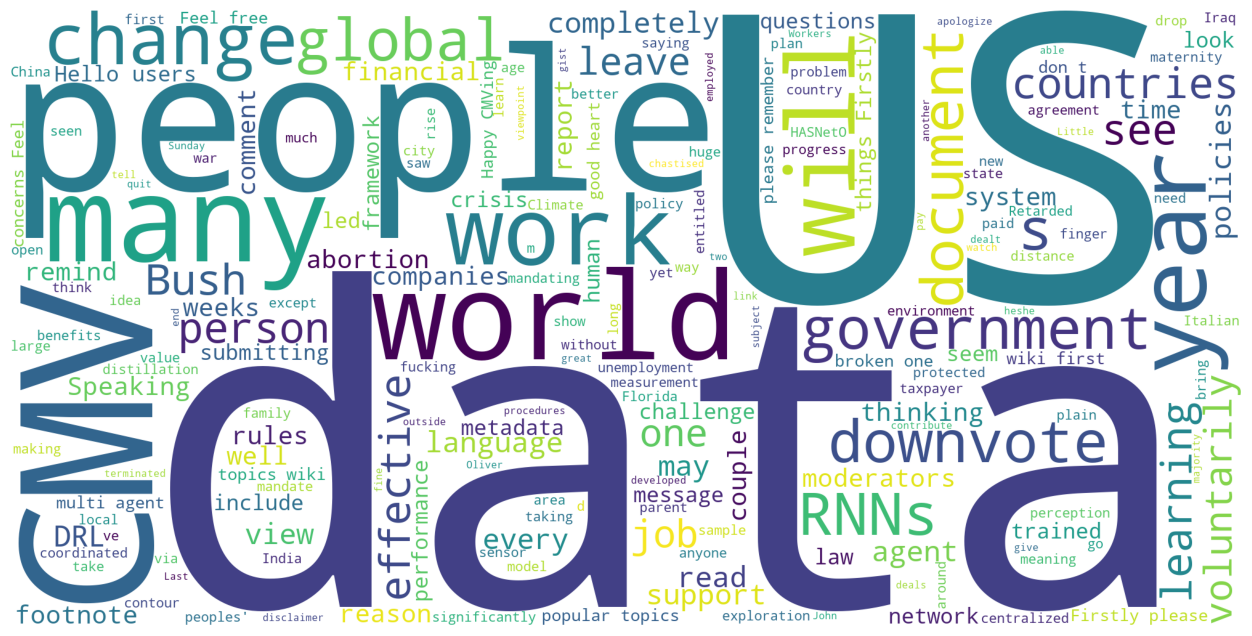

In [13]:
stopwords = set(STOPWORDS)
human = df[df['label'] == 1]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=1000, width=2000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Word Cloud on AI Responses

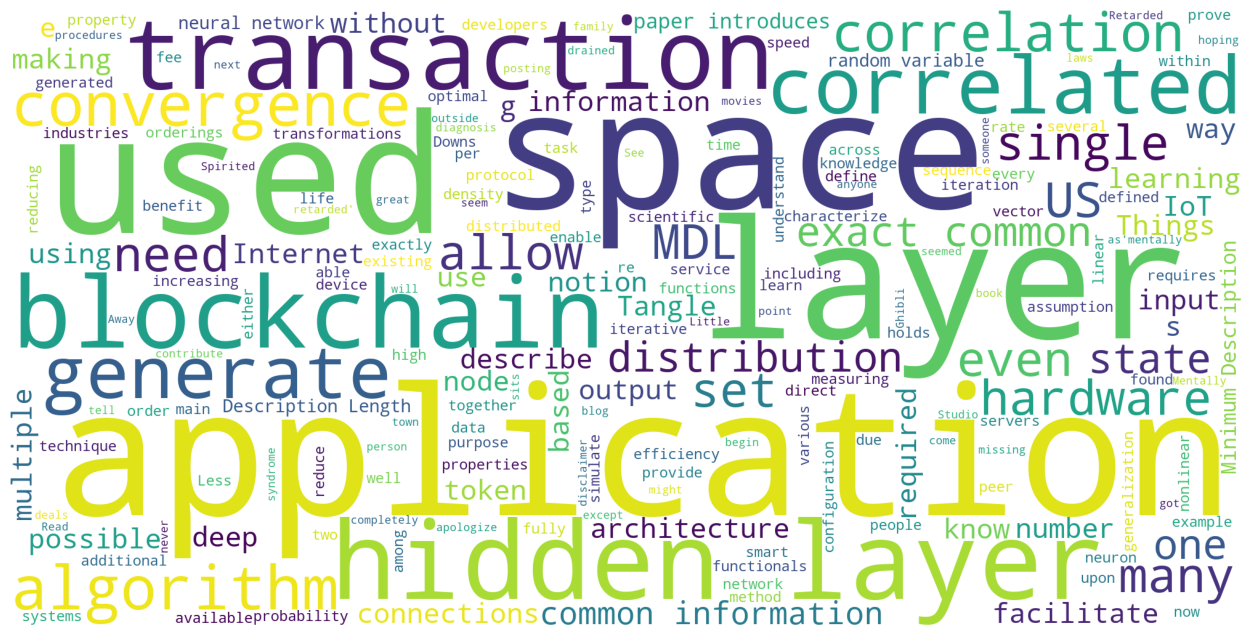

In [14]:
stopwords = set(STOPWORDS)
human = df[df['label'] == 0]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=1000, width=2000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We observe that the most commonly used words by humans and AIs are very different, with humans using words like "data", "us", or "people", and AIs using words like "application", "space", or "layer".

### Proportion of Texts between Humans and AIs

[Text(0, 0, 'Human'), Text(1, 0, 'AI')]

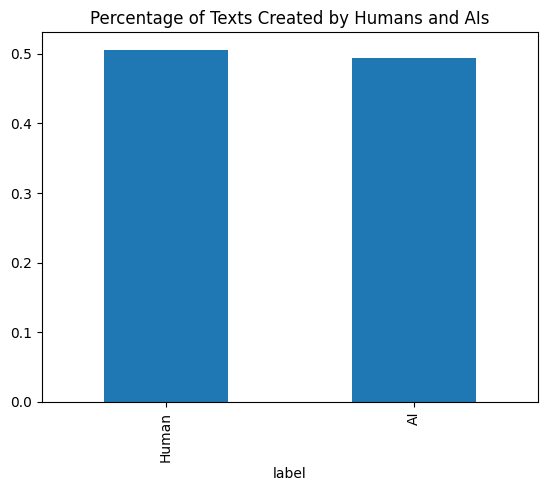

In [15]:
df.value_counts("label", normalize=True).plot(kind="bar", title= "Percentage of Texts Created by Humans and AIs").set_xticklabels(('Human', 'AI'))

We notice a uniform distribution between the 2 different labels, which will facilitate the models' learning.

## Benchmarking Different Machine Learning Models
---

Splitting the dataset into training and testing sets, with 80% for training and 20% for testing (which also serves as a validation set due to lack of data).

In [16]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

#### Training 5 machine learning models with grid search

The choice of models for grid search results from our research. These models seem to be the most suitable for binary text classification, but we would have liked to add others that also seemed promising.

The pipeline used for each model is quite simple. It consists of a **CountVectorizer**, which allows us to transcribe our character strings into vectors, followed by the model we want to test. **CountVectorizer** was chosen after several tests with different embedding methods, including **Word2Vec**, **FastText**, **TfIdf**, but a vector with the count of each word occurrence in the vocabulary seems to be the most suitable. We chose the ***punkt*** tokenizer from `nltk`.

**PS: The execution of this benchmark is very long. We advise you to trust our choice of the best machine learning model resulting from its execution.**

In [11]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100, 200]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1.0]}
    },
    'SVC': {
        'model': SVC(),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {'model__alpha': [0.01, 0.1, 1]}
    }
}

grid_search_objects = {}
results = {}

for name, m in models.items():
    pipe = Pipeline([
        ('count_vect', CountVectorizer(tokenizer=word_tokenize, ngram_range=(2, 2))),
        ('model', m['model'])
    ])
    grid_search = GridSearchCV(pipe, m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_objects[name] = grid_search
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

for name, res in results.items():
    print(f"{name}: Meilleure précision = {res['best_score']}")
    print(f"Meilleurs paramètres : {res['best_params']}")


#### Evaluation with test data of the best models

In [ ]:
for name, grid_search in grid_search_objects.items():
    best_model = grid_search.best_estimator_
    
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{name} Test Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Prediction Time: {prediction_time} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

## Optimization of the Best Machine Learning Model
---

With the benchmark we just performed, we quickly realize that the most performant machine learning model is **logistic regression**. Therefore, we will continue to improve this model with a larger grid search and an increase in the size of the n-grams of the **CountVectorizer**. We will also use cross-validation to obtain better metrics on the performance of our model.

#### Grid search and cross validation

In [ ]:
param_grid = {'logisticregression__max_iter': [100, 500, 1000], 'logisticregression__tol': [1e-4, 1e-5]}
model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(3, 3)), LogisticRegression())

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres trouvés via la recherche sur la grille : {grid_search.best_params_}")
print(f"Meilleure précision lors de la validation croisée : {grid_search.best_score_}")

Inference on Test Data:

In [ ]:
best_log_reg = grid_search.best_estimator_

start = time.time()
y_pred = best_log_reg.predict(X_test)
print(f"Temps d'inférence: {time.time() - start}")

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Matrice de confusion :

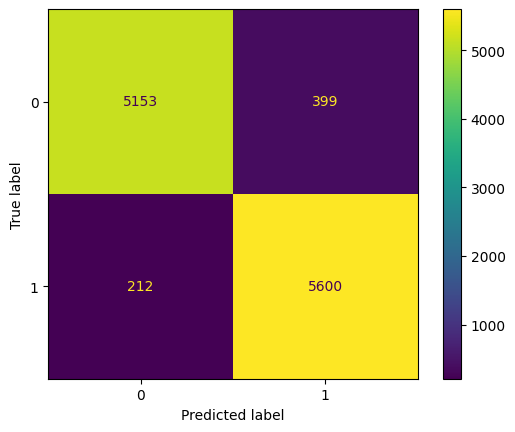

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot()
plt.show()

## Deep Learning Models
---
Converting the data into a TensorFlow dataset for training the models:

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).shuffle(5000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(32)

### RNN

Training a vectorization layer and defining the model.

In [ ]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(train_dataset.map(lambda text, _: text))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

Compilation, training, and testing of the RNN model.

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_delta=0.1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.AdamW(1e-4),
              metrics=['accuracy']
             )

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    callbacks=[early_stopping, reduce_lr])

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

### RNN with BERT

Importing a pre-trained **BERT** model and creating a special dataset with the tokenizer associated with the **BERT** model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

max_len = 120
X_train = tokenizer(
    text=df_train['text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test['text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

Définition du modèle **BERT** et **RNN**.

In [ ]:
class OwnBert(tf.keras.Layer):
    def call(self, ids, mask):
        return bert(ids, attention_mask=mask)[0]
    
x = OwnBert()(input_ids, input_mask)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=x)
model.layers[2].trainable = True # permet le training sur le modèle BERT déjà existant

Compilation, training, and testing of the **BERT** and **RNN** models.

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

history = model.fit(
    x = {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y = df_train['label'],
    validation_data = ({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, df_test['label']),
    epochs=10,
    batch_size=32
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.AdamW(1e-5),
    metrics=['accuracy']
)

history = model.fit(
    x = {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y = df_train['label'],
    validation_data = ({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, df_test['label']),
    epochs=1,
    batch_size=32
)

test_loss, test_acc = model.evaluate(x = {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, y = y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

## Conclusion
---

In [24]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(3, 3)), LogisticRegression(max_iter=500, random_state=42))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
              precision    recall  f1-score   support

           0     0.9605    0.9281    0.9440      5552
           1     0.9335    0.9635    0.9483      5812

    accuracy                         0.9462     11364
   macro avg     0.9470    0.9458    0.9462     11364
weighted avg     0.9467    0.9462    0.9462     11364



Our best machine learning model is therefore logistic regression coupled with the CountVectorizer from **scikit**, which uses the **punkt** tokenizer from `nltk`. CountVectorizer highlights important features that we observed in this dataset during data analysis, such as differences between text created by a human and text generated by an AI, especially in terms of text length, diversity of words used, number of spelling mistakes, etc. With the hyperparameters we found for logistic regression, we achieve an accuracy of about **95%**.

As for deep learning, the most performant model is the **RNN** coupled with the pre-trained **BERT** model (by Google), also with **95%** accuracy. With the limited amount of data provided, we are pleased with this result, as deep learning models often require a lot of data per parameter to perform well, but ours still manages to converge quite quickly.

Inference time is calculated for the inference of **20%** of the dataset, which is approximately **11,300** rows.

| Model          | Random Forest | Gradient Boost | SVM     | Naive Bayes | Logistic Reg | RNN   | BERT RNN |
| -------------- | ------------- | -------------- | ------- | ----------- | ------------ | ----- | -------- |
| Test Precision | 0.86          | 0.77           | 0.79    | 0.73        | ***0.95***   | 0.92  | ***0.95***     |
| Inference Time | 8s            | 2.7s           | 195s    | ***2s***    | 3s           | 8s    | 8s       |
| Training Consumption | Low         | Low          | Medium | Low       | Medium      | High | High    |